In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

Loaded data with shape: (13, 115)
Using top item: ITEM001
Prepared daily data length: 367
Unique dates: 367


c:\Users\ramyu\code\sql\lab\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 5.1916e-06 - val_loss: 4.6382e-06
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.1839e-06 - val_loss: 5.5245e-07
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.3371e-07 - val_loss: 6.3238e-07
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.5317e-07 - val_loss: 3.6375e-07
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.2746e-07 - val_loss: 1.6392e-07
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0823e-07 - val_loss: 7.5947e-09
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.7415e-08 - val_loss: 5.5884e-08
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.5447e-08 - val_loss: 1.2132e-08
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.5634e-08 - val_loss: 6.5300e-09
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1774e-08 - val_loss: 7.9083e-09
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.0736e-09 - val_loss: 4.0770e-

ValueError: Found array with dim 3, while dim <= 2 is required.

In [ ]:
# Step 1: Load data from Parquet
def load_data(file_path):
    df = pd.read_parquet(file_path)
    print(f"Loaded data with shape: {df.shape}")
    return df


# Step 2: Clean and preprocess data
def clean_and_prepare(df, item_code=None):
    # Select relevant columns (using OUTGOING_QUANTITY as demand proxy)
    df = df[["DOCUMENT_DATE", "ITEM_CODE", "OUTGOING_QUANTITY"]].copy()

    # Handle missing values
    df.dropna(subset=["DOCUMENT_DATE", "OUTGOING_QUANTITY"], inplace=True)
    df["OUTGOING_QUANTITY"] = df["OUTGOING_QUANTITY"].clip(
        lower=0
    )  # Ensure quantities >= 0

    # Convert date
    df["DOCUMENT_DATE"] = pd.to_datetime(df["DOCUMENT_DATE"])
    df.sort_values("DOCUMENT_DATE", inplace=True)

    # If specific item, filter; else, use top item by total outflow
    if item_code is None:
        top_item = df.groupby("ITEM_CODE")["OUTGOING_QUANTITY"].sum().idxmax()
        print(f"Using top item: {top_item}")
        df = df[df["ITEM_CODE"] == top_item]
    else:
        df = df[df["ITEM_CODE"] == item_code]

    # Aggregate daily outflows
    daily_df = df.groupby("DOCUMENT_DATE")["OUTGOING_QUANTITY"].sum().reset_index()
    daily_df.set_index("DOCUMENT_DATE", inplace=True)

    # Resample to daily frequency, fill missing with 0
    daily_df = daily_df.resample("D").sum().fillna(0)

    print(f"Prepared daily data length: {len(daily_df)}")
    print(f"Unique dates: {daily_df.index.nunique()}")

    return daily_df


# Step 3: Create time-series sequences (with dynamic adjustment for short data)
def create_sequences(data, seq_length=30, forecast_horizon=7):
    min_length = 10  # Minimum for meaningful forecasting
    if len(data) < min_length:
        raise ValueError(
            f"Data too short ({len(data)}) for forecasting. Need at least {min_length} entries."
        )

    if len(data) < seq_length + forecast_horizon:
        seq_length = max(1, len(data) // 2)
        forecast_horizon = max(1, len(data) - seq_length)
        print(
            f"Adjusted seq_length={seq_length}, forecast_horizon={forecast_horizon} due to short data ({len(data)} entries)"
        )

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - seq_length - forecast_horizon + 1):
        X.append(scaled_data[i : i + seq_length])
        y.append(scaled_data[i + seq_length : i + seq_length + forecast_horizon])

    if len(X) == 0:
        raise ValueError(
            "No sequences could be created. Data may be too short after adjustments."
        )

    return np.array(X), np.array(y), scaler


# Step 4: Build and train LSTM model
def train_lstm(X_train, y_train, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(y_train.shape[1]))  # Output for forecast horizon

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1,
    )

    return model, history


# Step 5: Evaluate model (skip if no test data)
def evaluate_model(model, X_test, y_test, scaler):
    if len(X_test) == 0 or len(y_test) == 0:
        print("No test data available for evaluation. Skipping.")
        return

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test)

    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

    # Plot sample predictions
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.flatten(), label="Actual")
    plt.plot(predictions.flatten(), label="Predicted")
    plt.title("Actual vs Predicted Outflow")
    plt.legend()
    plt.show()

In [ ]:
file_path = "data/INV_V_ITM_MOVMNT_AI.parquet"  # Single table with required fields
df = load_data(file_path)
prepared_df = clean_and_prepare(df)  # Use top item; or pass item_code='your_code'

In [ ]:
data = prepared_df["OUTGOING_QUANTITY"]
X, y, scaler = create_sequences(data)

In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
model, history = train_lstm(X_train, y_train)

In [ ]:
evaluate_model(model, X_test, y_test, scaler)

In [ ]:
model.save("lstm_demand_model.h5")

Loaded data with shape: (13, 115)
Using top item: ITEM001
Prepared daily data length: 367
Unique dates: 367
Epoch 1/50


c:\Users\ramyu\code\sql\lab\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 3.7985e-06 - val_loss: 3.2321e-06
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.1859e-06 - val_loss: 1.1562e-06
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.2024e-07 - val_loss: 7.6651e-07
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.1183e-07 - val_loss: 1.9500e-08
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.7998e-07 - val_loss: 1.7786e-07
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0789e-07 - val_loss: 7.9984e-08
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.3132e-08 - val_loss: 1.2928e-08
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.9691e-08 - val_loss: 2.2834e-08
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.4313e-08 - val_loss: 8.0270e-09
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.6305e-09 - val_loss: 9.1847e-10
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.6675e-09 - val_loss: 3.1801e-09
Epoch 12

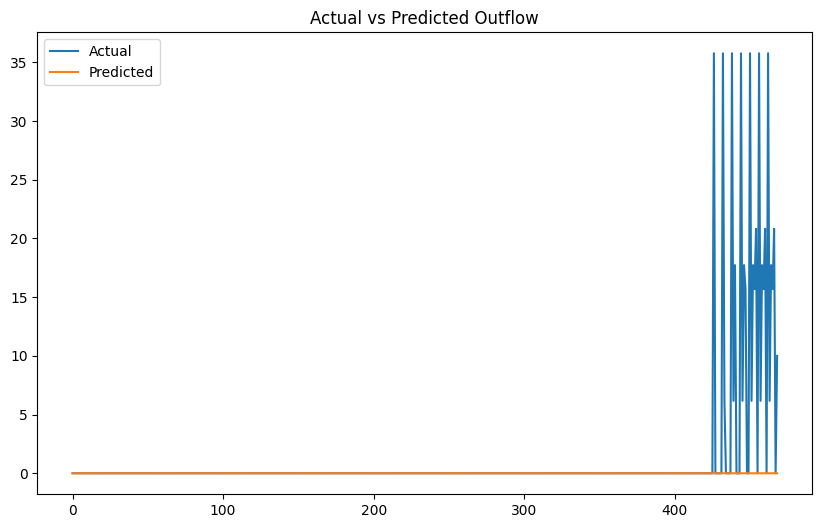

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Step 1: Load data from Parquet
def load_data(file_path):
    df = pd.read_parquet(file_path)
    print(f"Loaded data with shape: {df.shape}")
    return df

# Step 2: Clean and preprocess data
def clean_and_prepare(df, item_code=None):
    # Select relevant columns (using OUTGOING_QUANTITY as demand proxy)
    df = df[['DOCUMENT_DATE', 'ITEM_CODE', 'OUTGOING_QUANTITY']].copy()
    
    # Handle missing values
    df.dropna(subset=['DOCUMENT_DATE', 'OUTGOING_QUANTITY'], inplace=True)
    df['OUTGOING_QUANTITY'] = df['OUTGOING_QUANTITY'].clip(lower=0)  # Ensure quantities >= 0
    
    # Convert date
    df['DOCUMENT_DATE'] = pd.to_datetime(df['DOCUMENT_DATE'])
    df.sort_values('DOCUMENT_DATE', inplace=True)
    
    # If specific item, filter; else, use top item by total outflow
    if item_code is None:
        top_item = df.groupby('ITEM_CODE')['OUTGOING_QUANTITY'].sum().idxmax()
        print(f"Using top item: {top_item}")
        df = df[df['ITEM_CODE'] == top_item]
    else:
        df = df[df['ITEM_CODE'] == item_code]
    
    # Aggregate daily outflows
    daily_df = df.groupby('DOCUMENT_DATE')['OUTGOING_QUANTITY'].sum().reset_index()
    daily_df.set_index('DOCUMENT_DATE', inplace=True)
    
    # Resample to daily frequency, fill missing with 0
    daily_df = daily_df.resample('D').sum().fillna(0)
    
    print(f"Prepared daily data length: {len(daily_df)}")
    print(f"Unique dates: {daily_df.index.nunique()}")
    
    return daily_df

# Step 3: Create time-series sequences (with dynamic adjustment for short data)
def create_sequences(data, seq_length=30, forecast_horizon=7):
    min_length = 10  # Minimum for meaningful forecasting
    if len(data) < min_length:
        raise ValueError(f"Data too short ({len(data)}) for forecasting. Need at least {min_length} entries.")
    
    if len(data) < seq_length + forecast_horizon:
        seq_length = max(1, len(data) // 2)
        forecast_horizon = max(1, len(data) - seq_length)
        print(f"Adjusted seq_length={seq_length}, forecast_horizon={forecast_horizon} due to short data ({len(data)} entries)")
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(len(scaled_data) - seq_length - forecast_horizon + 1):
        X.append(scaled_data[i:i + seq_length])
        y.append(scaled_data[i + seq_length:i + seq_length + forecast_horizon].flatten())
    
    if len(X) == 0:
        raise ValueError("No sequences could be created. Data may be too short after adjustments.")
    
    return np.array(X), np.array(y), scaler

# Step 4: Build and train LSTM model
def train_lstm(X_train, y_train, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(y_train.shape[1]))  # Output for forecast horizon
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
    
    return model, history

# Step 5: Evaluate model (skip if no test data)
def evaluate_model(model, X_test, y_test, scaler):
    if len(X_test) == 0 or len(y_test) == 0:
        print("No test data available for evaluation. Skipping.")
        return
    
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test)
    
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    # Plot sample predictions
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.flatten(), label='Actual')
    plt.plot(predictions.flatten(), label='Predicted')
    plt.title('Actual vs Predicted Outflow')
    plt.legend()
    plt.show()

# Main execution
if __name__ == "__main__":
    file_path = 'data/INV_V_ITM_MOVMNT_AI.parquet'  # Single table with required fields
    df = load_data(file_path)
    prepared_df = clean_and_prepare(df)  # Use top item; or pass item_code='your_code'
    
    data = prepared_df['OUTGOING_QUANTITY']
    X, y, scaler = create_sequences(data)
    
    # Split train/test (80/20), but handle small X
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    model, history = train_lstm(X_train, y_train)
    evaluate_model(model, X_test, y_test, scaler)
    
    # Save model (optional)
    model.save('lstm_demand_model.h5')

In [16]:
last_sequence = scaler.transform(data[-30:].values.reshape(-1, 1))
last_sequence = last_sequence.reshape(1, 30, 1)

# Forecast next forecast_horizon days
forecast = model.predict(last_sequence)
forecast = scaler.inverse_transform(forecast)

# Generate future dates
last_date = prepared_df.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1))

# Create forecast DataFrame
forecast_df = pd.DataFrame(forecast.flatten(), index=future_dates, columns=['Forecasted Outflow'])

print("Forecasted Outgoing Quantities:")
print(forecast_df)

# Plot historical data + forecast
plt.figure(figsize=(12, 6))
plt.plot(prepared_df.index, prepared_df['OUTGOING_QUANTITY'], label='Historical')
plt.plot(forecast_df.index, forecast_df['Forecasted Outflow'], label='Forecast', color='red')
plt.title('Historical and Forecasted Outflow')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


ValueError: Of the four parameters: start, end, periods, and freq, exactly three must be specified